In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [18]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[2] += v[2]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b and x[2]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b and x[2]<b:
            ch = 1.0
            stop = True
        elif x[2]>= b and x[0]<b and x[1]<b:
            ch = 2.0
            stop = True
        elif (x[0]>= b and x[1]>=b) or (x[1]>= b and x[2]>=b) or (x[0]>= b and x[2]>=b):
            rt = 0
            x = np.array([0.0, 0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('_data/Kr2011.csv')
data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['rt'] /= 1000

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)
data_df['sbj'] += 1

data_df['choice_0'] = pd.get_dummies(data_df['choice'])[0]
data_df['choice_1'] = pd.get_dummies(data_df['choice'])[1]
data_df['choice_2'] = pd.get_dummies(data_df['choice'])[2]

# data_df = data_df[data_df['sbj']<11]

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
data_df

,sbj,trial,rt,choice,item_value_0,item_value_1,item_value_2,gaze_0,gaze_1,gaze_2,rt_max,choice_0,choice_1,choice_2
0,1,0,1.782,1,1,7,3,0.096864,0.791638,0.111498,2.143677,0,1,0
1,1,1,1.063,1,7,3,2,0.177738,0.500898,0.321364,2.143677,0,1,0
2,1,2,1.171,2,3,1,2,0.534224,0.000000,0.465776,2.143677,0,0,1
3,1,3,1.368,0,3,1,2,0.626604,0.000000,0.373396,2.143677,1,0,0
4,1,4,1.476,0,6,1,3,0.340448,0.488794,0.170758,2.143677,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,30,95,1.525,1,5,4,1,0.153191,0.508936,0.337872,3.303418,0,1,0
2918,30,96,1.585,0,9,6,2,0.483682,0.316318,0.200000,3.303418,1,0,0
2919,30,97,1.506,1,5,7,2,0.246032,0.438272,0.315697,3.303418,0,1,0
2920,30,98,1.752,2,1,4,2,0.267964,0.164671,0.567365,3.303418,0,0,1


In [6]:
tr_df, ts_df = make_train_test(data_df, test_size=0.5)

obs_train = np.asarray(tr_df[['rt', 'choice_0', 'choice_1', 'choice_2']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'item_value_2', 
                            'gaze_0', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'choice_0', 'choice_1', 'choice_2']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'item_value_2', 
                           'gaze_0', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(1454, 6) (1468, 6)


In [7]:
def fpt(t, b, v):
    return b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))

In [8]:
def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    
    ll1 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, pred[:, 1])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, pred[:, 2]))
    ll2 = (obs_train[:, 2]) * fpt(obs_train[:, 0]-ndt, thr, pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, pred[:, 2]))
    ll3 = (obs_train[:, 3]) * fpt(obs_train[:, 0]-ndt, thr, pred[:, 2]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, pred[:, 1]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + ll3), axis=-1)

In [9]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=3, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))

In [10]:
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [11]:
layers_neuron = [10, 10, 10, 10]
input_shape = 6
output_shape = 3
activation = 'sigmoid'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                70        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 out_layer (Out_layer)       (None, 3)                 93        
                                                                 
Total params: 493 (1.93 KB)
Trainable params: 493 (1.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
history = model.fit(X_train, obs_train, shuffle=False, batch_size=X_train.shape[0], epochs=2500)

Epoch 1/2500
1/1 [==============================] - 21s 21s/step - loss: 16895.1602
Epoch 2/2500
1/1 [==============================] - 0s 8ms/step - loss: 16730.5488
Epoch 3/2500
1/1 [==============================] - 0s 9ms/step - loss: 16614.2227
Epoch 4/2500
1/1 [==============================] - 0s 11ms/step - loss: 16518.5254
Epoch 5/2500
1/1 [==============================] - 0s 12ms/step - loss: 16434.7461
Epoch 6/2500
1/1 [==============================] - 0s 9ms/step - loss: 16358.8555
Epoch 7/2500
1/1 [==============================] - 0s 11ms/step - loss: 16288.6133
Epoch 8/2500
1/1 [==============================] - 0s 8ms/step - loss: 16222.6201
Epoch 9/2500
1/1 [==============================] - 0s 11ms/step - loss: 16159.9336
Epoch 10/2500
1/1 [==============================] - 0s 9ms/step - loss: 16099.8916
Epoch 11/2500
1/1 [==============================] - 0s 8ms/step - loss: 16042.0059
Epoch 12/2500
1/1 [==============================] - 0s 9ms/step - loss: 15985.9

1/1 [==============================] - 0s 11ms/step - loss: 12626.4248
Epoch 99/2500
1/1 [==============================] - 0s 11ms/step - loss: 12596.9521
Epoch 100/2500
1/1 [==============================] - 0s 11ms/step - loss: 12567.6943
Epoch 101/2500
1/1 [==============================] - 0s 11ms/step - loss: 12538.6455
Epoch 102/2500
1/1 [==============================] - 0s 11ms/step - loss: 12509.8086
Epoch 103/2500
1/1 [==============================] - 0s 11ms/step - loss: 12481.1807
Epoch 104/2500
1/1 [==============================] - 0s 10ms/step - loss: 12452.7646
Epoch 105/2500
1/1 [==============================] - 0s 11ms/step - loss: 12424.5566
Epoch 106/2500
1/1 [==============================] - 0s 11ms/step - loss: 12396.5566
Epoch 107/2500
1/1 [==============================] - 0s 10ms/step - loss: 12368.7666
Epoch 108/2500
1/1 [==============================] - 0s 11ms/step - loss: 12341.1846
Epoch 109/2500
1/1 [==============================] - 0s 11ms/step - l

1/1 [==============================] - 0s 10ms/step - loss: 10642.2969
Epoch 194/2500
1/1 [==============================] - 0s 11ms/step - loss: 10628.5215
Epoch 195/2500
1/1 [==============================] - 0s 11ms/step - loss: 10614.8584
Epoch 196/2500
1/1 [==============================] - 0s 11ms/step - loss: 10601.3047
Epoch 197/2500
1/1 [==============================] - 0s 10ms/step - loss: 10587.8604
Epoch 198/2500
1/1 [==============================] - 0s 11ms/step - loss: 10574.5234
Epoch 199/2500
1/1 [==============================] - 0s 10ms/step - loss: 10561.2930
Epoch 200/2500
1/1 [==============================] - 0s 10ms/step - loss: 10548.1670
Epoch 201/2500
1/1 [==============================] - 0s 10ms/step - loss: 10535.1475
Epoch 202/2500
1/1 [==============================] - 0s 11ms/step - loss: 10522.2285
Epoch 203/2500
1/1 [==============================] - 0s 11ms/step - loss: 10509.4141
Epoch 204/2500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 9696.2432
Epoch 289/2500
1/1 [==============================] - 0s 11ms/step - loss: 9688.9941
Epoch 290/2500
1/1 [==============================] - 0s 10ms/step - loss: 9681.7812
Epoch 291/2500
1/1 [==============================] - 0s 11ms/step - loss: 9674.6074
Epoch 292/2500
1/1 [==============================] - 0s 10ms/step - loss: 9667.4688
Epoch 293/2500
1/1 [==============================] - 0s 10ms/step - loss: 9660.3643
Epoch 294/2500
1/1 [==============================] - 0s 11ms/step - loss: 9653.2949
Epoch 295/2500
1/1 [==============================] - 0s 11ms/step - loss: 9646.2627
Epoch 296/2500
1/1 [==============================] - 0s 11ms/step - loss: 9639.2637
Epoch 297/2500
1/1 [==============================] - 0s 11ms/step - loss: 9632.2979
Epoch 298/2500
1/1 [==============================] - 0s 11ms/step - loss: 9625.3672
Epoch 299/2500
1/1 [==============================] - 0s 10ms/step - loss: 9618.

1/1 [==============================] - 0s 11ms/step - loss: 9122.2754
Epoch 385/2500
1/1 [==============================] - 0s 11ms/step - loss: 9117.2227
Epoch 386/2500
1/1 [==============================] - 0s 11ms/step - loss: 9112.1826
Epoch 387/2500
1/1 [==============================] - 0s 10ms/step - loss: 9107.1562
Epoch 388/2500
1/1 [==============================] - 0s 11ms/step - loss: 9102.1445
Epoch 389/2500
1/1 [==============================] - 0s 10ms/step - loss: 9097.1455
Epoch 390/2500
1/1 [==============================] - 0s 11ms/step - loss: 9092.1592
Epoch 391/2500
1/1 [==============================] - 0s 10ms/step - loss: 9087.1846
Epoch 392/2500
1/1 [==============================] - 0s 11ms/step - loss: 9082.2246
Epoch 393/2500
1/1 [==============================] - 0s 11ms/step - loss: 9077.2773
Epoch 394/2500
1/1 [==============================] - 0s 11ms/step - loss: 9072.3418
Epoch 395/2500
1/1 [==============================] - 0s 10ms/step - loss: 9067.

1/1 [==============================] - 0s 11ms/step - loss: 8687.1191
Epoch 481/2500
1/1 [==============================] - 0s 11ms/step - loss: 8683.0234
Epoch 482/2500
1/1 [==============================] - 0s 10ms/step - loss: 8678.9355
Epoch 483/2500
1/1 [==============================] - 0s 11ms/step - loss: 8674.8555
Epoch 484/2500
1/1 [==============================] - 0s 10ms/step - loss: 8670.7822
Epoch 485/2500
1/1 [==============================] - 0s 10ms/step - loss: 8666.7188
Epoch 486/2500
1/1 [==============================] - 0s 11ms/step - loss: 8662.6602
Epoch 487/2500
1/1 [==============================] - 0s 10ms/step - loss: 8658.6113
Epoch 488/2500
1/1 [==============================] - 0s 10ms/step - loss: 8654.5674
Epoch 489/2500
1/1 [==============================] - 0s 11ms/step - loss: 8650.5322
Epoch 490/2500
1/1 [==============================] - 0s 10ms/step - loss: 8646.5059
Epoch 491/2500
1/1 [==============================] - 0s 10ms/step - loss: 8642.

1/1 [==============================] - 0s 11ms/step - loss: 8325.8838
Epoch 577/2500
1/1 [==============================] - 0s 11ms/step - loss: 8322.4375
Epoch 578/2500
1/1 [==============================] - 0s 11ms/step - loss: 8318.9980
Epoch 579/2500
1/1 [==============================] - 0s 11ms/step - loss: 8315.5645
Epoch 580/2500
1/1 [==============================] - 0s 11ms/step - loss: 8312.1357
Epoch 581/2500
1/1 [==============================] - 0s 10ms/step - loss: 8308.7148
Epoch 582/2500
1/1 [==============================] - 0s 11ms/step - loss: 8305.3008
Epoch 583/2500
1/1 [==============================] - 0s 11ms/step - loss: 8301.8916
Epoch 584/2500
1/1 [==============================] - 0s 11ms/step - loss: 8298.4883
Epoch 585/2500
1/1 [==============================] - 0s 11ms/step - loss: 8295.0908
Epoch 586/2500
1/1 [==============================] - 0s 11ms/step - loss: 8291.7002
Epoch 587/2500
1/1 [==============================] - 0s 12ms/step - loss: 8288.

1/1 [==============================] - 0s 10ms/step - loss: 8022.0415
Epoch 673/2500
1/1 [==============================] - 0s 11ms/step - loss: 8019.1548
Epoch 674/2500
1/1 [==============================] - 0s 11ms/step - loss: 8016.2739
Epoch 675/2500
1/1 [==============================] - 0s 11ms/step - loss: 8013.3994
Epoch 676/2500
1/1 [==============================] - 0s 11ms/step - loss: 8010.5298
Epoch 677/2500
1/1 [==============================] - 0s 11ms/step - loss: 8007.6670
Epoch 678/2500
1/1 [==============================] - 0s 11ms/step - loss: 8004.8086
Epoch 679/2500
1/1 [==============================] - 0s 10ms/step - loss: 8001.9551
Epoch 680/2500
1/1 [==============================] - 0s 11ms/step - loss: 7999.1099
Epoch 681/2500
1/1 [==============================] - 0s 10ms/step - loss: 7996.2681
Epoch 682/2500
1/1 [==============================] - 0s 10ms/step - loss: 7993.4331
Epoch 683/2500
1/1 [==============================] - 0s 11ms/step - loss: 7990.

1/1 [==============================] - 0s 12ms/step - loss: 7770.4277
Epoch 769/2500
1/1 [==============================] - 0s 11ms/step - loss: 7768.0669
Epoch 770/2500
1/1 [==============================] - 0s 12ms/step - loss: 7765.7109
Epoch 771/2500
1/1 [==============================] - 0s 11ms/step - loss: 7763.3604
Epoch 772/2500
1/1 [==============================] - 0s 11ms/step - loss: 7761.0146
Epoch 773/2500
1/1 [==============================] - 0s 11ms/step - loss: 7758.6733
Epoch 774/2500
1/1 [==============================] - 0s 11ms/step - loss: 7756.3369
Epoch 775/2500
1/1 [==============================] - 0s 12ms/step - loss: 7754.0063
Epoch 776/2500
1/1 [==============================] - 0s 11ms/step - loss: 7751.6807
Epoch 777/2500
1/1 [==============================] - 0s 11ms/step - loss: 7749.3599
Epoch 778/2500
1/1 [==============================] - 0s 11ms/step - loss: 7747.0449
Epoch 779/2500
1/1 [==============================] - 0s 12ms/step - loss: 7744.

1/1 [==============================] - 0s 11ms/step - loss: 7566.0073
Epoch 865/2500
1/1 [==============================] - 0s 11ms/step - loss: 7564.1055
Epoch 866/2500
1/1 [==============================] - 0s 10ms/step - loss: 7562.2075
Epoch 867/2500
1/1 [==============================] - 0s 11ms/step - loss: 7560.3145
Epoch 868/2500
1/1 [==============================] - 0s 11ms/step - loss: 7558.4248
Epoch 869/2500
1/1 [==============================] - 0s 10ms/step - loss: 7556.5400
Epoch 870/2500
1/1 [==============================] - 0s 11ms/step - loss: 7554.6611
Epoch 871/2500
1/1 [==============================] - 0s 11ms/step - loss: 7552.7847
Epoch 872/2500
1/1 [==============================] - 0s 10ms/step - loss: 7550.9136
Epoch 873/2500
1/1 [==============================] - 0s 10ms/step - loss: 7549.0469
Epoch 874/2500
1/1 [==============================] - 0s 10ms/step - loss: 7547.1855
Epoch 875/2500
1/1 [==============================] - 0s 10ms/step - loss: 7545.

1/1 [==============================] - 0s 11ms/step - loss: 7403.2607
Epoch 961/2500
1/1 [==============================] - 0s 11ms/step - loss: 7401.7705
Epoch 962/2500
1/1 [==============================] - 0s 10ms/step - loss: 7400.2842
Epoch 963/2500
1/1 [==============================] - 0s 11ms/step - loss: 7398.8018
Epoch 964/2500
1/1 [==============================] - 0s 11ms/step - loss: 7397.3237
Epoch 965/2500
1/1 [==============================] - 0s 11ms/step - loss: 7395.8496
Epoch 966/2500
1/1 [==============================] - 0s 11ms/step - loss: 7394.3799
Epoch 967/2500
1/1 [==============================] - 0s 10ms/step - loss: 7392.9146
Epoch 968/2500
1/1 [==============================] - 0s 10ms/step - loss: 7391.4526
Epoch 969/2500
1/1 [==============================] - 0s 11ms/step - loss: 7389.9951
Epoch 970/2500
1/1 [==============================] - 0s 11ms/step - loss: 7388.5415
Epoch 971/2500
1/1 [==============================] - 0s 11ms/step - loss: 7387.

1/1 [==============================] - 0s 11ms/step - loss: 7278.1216
Epoch 1056/2500
1/1 [==============================] - 0s 12ms/step - loss: 7276.9595
Epoch 1057/2500
1/1 [==============================] - 0s 11ms/step - loss: 7275.8013
Epoch 1058/2500
1/1 [==============================] - 0s 11ms/step - loss: 7274.6450
Epoch 1059/2500
1/1 [==============================] - 0s 10ms/step - loss: 7273.4912
Epoch 1060/2500
1/1 [==============================] - 0s 11ms/step - loss: 7272.3418
Epoch 1061/2500
1/1 [==============================] - 0s 11ms/step - loss: 7271.1938
Epoch 1062/2500
1/1 [==============================] - 0s 11ms/step - loss: 7270.0483
Epoch 1063/2500
1/1 [==============================] - 0s 11ms/step - loss: 7268.9058
Epoch 1064/2500
1/1 [==============================] - 0s 11ms/step - loss: 7267.7671
Epoch 1065/2500
1/1 [==============================] - 0s 11ms/step - loss: 7266.6294
Epoch 1066/2500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 7177.7393
Epoch 1151/2500
1/1 [==============================] - 0s 11ms/step - loss: 7176.7607
Epoch 1152/2500
1/1 [==============================] - 0s 11ms/step - loss: 7175.7832
Epoch 1153/2500
1/1 [==============================] - 0s 10ms/step - loss: 7174.8062
Epoch 1154/2500
1/1 [==============================] - 0s 10ms/step - loss: 7173.8301
Epoch 1155/2500
1/1 [==============================] - 0s 10ms/step - loss: 7172.8555
Epoch 1156/2500
1/1 [==============================] - 0s 11ms/step - loss: 7171.8809
Epoch 1157/2500
1/1 [==============================] - 0s 10ms/step - loss: 7170.9087
Epoch 1158/2500
1/1 [==============================] - 0s 10ms/step - loss: 7169.9365
Epoch 1159/2500
1/1 [==============================] - 0s 11ms/step - loss: 7168.9658
Epoch 1160/2500
1/1 [==============================] - 0s 11ms/step - loss: 7167.9951
Epoch 1161/2500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 7088.9819
Epoch 1246/2500
1/1 [==============================] - 0s 11ms/step - loss: 7088.1211
Epoch 1247/2500
1/1 [==============================] - 0s 11ms/step - loss: 7087.2622
Epoch 1248/2500
1/1 [==============================] - 0s 10ms/step - loss: 7086.4062
Epoch 1249/2500
1/1 [==============================] - 0s 10ms/step - loss: 7085.5542
Epoch 1250/2500
1/1 [==============================] - 0s 11ms/step - loss: 7084.7041
Epoch 1251/2500
1/1 [==============================] - 0s 11ms/step - loss: 7083.8574
Epoch 1252/2500
1/1 [==============================] - 0s 11ms/step - loss: 7083.0146
Epoch 1253/2500
1/1 [==============================] - 0s 11ms/step - loss: 7082.1738
Epoch 1254/2500
1/1 [==============================] - 0s 11ms/step - loss: 7081.3364
Epoch 1255/2500
1/1 [==============================] - 0s 10ms/step - loss: 7080.5029
Epoch 1256/2500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 7016.3496
Epoch 1341/2500
1/1 [==============================] - 0s 11ms/step - loss: 7015.6064
Epoch 1342/2500
1/1 [==============================] - 0s 10ms/step - loss: 7014.8608
Epoch 1343/2500
1/1 [==============================] - 0s 11ms/step - loss: 7014.1167
Epoch 1344/2500
1/1 [==============================] - 0s 10ms/step - loss: 7013.3721
Epoch 1345/2500
1/1 [==============================] - 0s 10ms/step - loss: 7012.6274
Epoch 1346/2500
1/1 [==============================] - 0s 11ms/step - loss: 7011.8823
Epoch 1347/2500
1/1 [==============================] - 0s 11ms/step - loss: 7011.1343
Epoch 1348/2500
1/1 [==============================] - 0s 10ms/step - loss: 7010.3877
Epoch 1349/2500
1/1 [==============================] - 0s 11ms/step - loss: 7009.6411
Epoch 1350/2500
1/1 [==============================] - 0s 11ms/step - loss: 7008.8945
Epoch 1351/2500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 6943.0811
Epoch 1436/2500
1/1 [==============================] - 0s 10ms/step - loss: 6942.2715
Epoch 1437/2500
1/1 [==============================] - 0s 11ms/step - loss: 6941.4614
Epoch 1438/2500
1/1 [==============================] - 0s 11ms/step - loss: 6940.6499
Epoch 1439/2500
1/1 [==============================] - 0s 11ms/step - loss: 6939.8389
Epoch 1440/2500
1/1 [==============================] - 0s 11ms/step - loss: 6939.0273
Epoch 1441/2500
1/1 [==============================] - 0s 11ms/step - loss: 6938.2144
Epoch 1442/2500
1/1 [==============================] - 0s 10ms/step - loss: 6937.4023
Epoch 1443/2500
1/1 [==============================] - 0s 11ms/step - loss: 6936.5889
Epoch 1444/2500
1/1 [==============================] - 0s 16ms/step - loss: 6935.7739
Epoch 1445/2500
1/1 [==============================] - 0s 11ms/step - loss: 6934.9585
Epoch 1446/2500
1/1 [==============================] - 0s 10ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 6859.4141
Epoch 1531/2500
1/1 [==============================] - 0s 11ms/step - loss: 6858.3770
Epoch 1532/2500
1/1 [==============================] - 0s 11ms/step - loss: 6857.3350
Epoch 1533/2500
1/1 [==============================] - 0s 11ms/step - loss: 6856.2866
Epoch 1534/2500
1/1 [==============================] - 0s 11ms/step - loss: 6855.2344
Epoch 1535/2500
1/1 [==============================] - 0s 11ms/step - loss: 6854.1768
Epoch 1536/2500
1/1 [==============================] - 0s 11ms/step - loss: 6853.1147
Epoch 1537/2500
1/1 [==============================] - 0s 11ms/step - loss: 6852.0459
Epoch 1538/2500
1/1 [==============================] - 0s 11ms/step - loss: 6850.9731
Epoch 1539/2500
1/1 [==============================] - 0s 11ms/step - loss: 6849.8940
Epoch 1540/2500
1/1 [==============================] - 0s 11ms/step - loss: 6848.8110
Epoch 1541/2500
1/1 [==============================] - 0s 10ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 6734.3857
Epoch 1626/2500
1/1 [==============================] - 0s 11ms/step - loss: 6732.7671
Epoch 1627/2500
1/1 [==============================] - 0s 10ms/step - loss: 6731.1416
Epoch 1628/2500
1/1 [==============================] - 0s 11ms/step - loss: 6729.5098
Epoch 1629/2500
1/1 [==============================] - 0s 11ms/step - loss: 6727.8721
Epoch 1630/2500
1/1 [==============================] - 0s 10ms/step - loss: 6726.2285
Epoch 1631/2500
1/1 [==============================] - 0s 10ms/step - loss: 6724.5791
Epoch 1632/2500
1/1 [==============================] - 0s 10ms/step - loss: 6722.9238
Epoch 1633/2500
1/1 [==============================] - 0s 10ms/step - loss: 6721.2622
Epoch 1634/2500
1/1 [==============================] - 0s 11ms/step - loss: 6719.5957
Epoch 1635/2500
1/1 [==============================] - 0s 11ms/step - loss: 6717.9214
Epoch 1636/2500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 12ms/step - loss: 6558.8145
Epoch 1721/2500
1/1 [==============================] - 0s 11ms/step - loss: 6556.8472
Epoch 1722/2500
1/1 [==============================] - 0s 11ms/step - loss: 6554.8809
Epoch 1723/2500
1/1 [==============================] - 0s 12ms/step - loss: 6552.9146
Epoch 1724/2500
1/1 [==============================] - 0s 11ms/step - loss: 6550.9492
Epoch 1725/2500
1/1 [==============================] - 0s 11ms/step - loss: 6548.9844
Epoch 1726/2500
1/1 [==============================] - 0s 12ms/step - loss: 6547.0200
Epoch 1727/2500
1/1 [==============================] - 0s 11ms/step - loss: 6545.0557
Epoch 1728/2500
1/1 [==============================] - 0s 12ms/step - loss: 6543.0928
Epoch 1729/2500
1/1 [==============================] - 0s 12ms/step - loss: 6541.1313
Epoch 1730/2500
1/1 [==============================] - 0s 11ms/step - loss: 6539.1689
Epoch 1731/2500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 6383.1167
Epoch 1816/2500
1/1 [==============================] - 0s 11ms/step - loss: 6381.4658
Epoch 1817/2500
1/1 [==============================] - 0s 10ms/step - loss: 6379.8198
Epoch 1818/2500
1/1 [==============================] - 0s 11ms/step - loss: 6378.1772
Epoch 1819/2500
1/1 [==============================] - 0s 11ms/step - loss: 6376.5415
Epoch 1820/2500
1/1 [==============================] - 0s 10ms/step - loss: 6374.9087
Epoch 1821/2500
1/1 [==============================] - 0s 11ms/step - loss: 6373.2812
Epoch 1822/2500
1/1 [==============================] - 0s 11ms/step - loss: 6371.6577
Epoch 1823/2500
1/1 [==============================] - 0s 10ms/step - loss: 6370.0386
Epoch 1824/2500
1/1 [==============================] - 0s 11ms/step - loss: 6368.4248
Epoch 1825/2500
1/1 [==============================] - 0s 11ms/step - loss: 6366.8159
Epoch 1826/2500
1/1 [==============================] - 0s 12ms/step - 

1/1 [==============================] - 0s 13ms/step - loss: 6245.4897
Epoch 1911/2500
1/1 [==============================] - 0s 11ms/step - loss: 6244.1787
Epoch 1912/2500
1/1 [==============================] - 0s 12ms/step - loss: 6242.8701
Epoch 1913/2500
1/1 [==============================] - 0s 12ms/step - loss: 6241.5610
Epoch 1914/2500
1/1 [==============================] - 0s 11ms/step - loss: 6240.2520
Epoch 1915/2500
1/1 [==============================] - 0s 13ms/step - loss: 6238.9448
Epoch 1916/2500
1/1 [==============================] - 0s 10ms/step - loss: 6237.6382
Epoch 1917/2500
1/1 [==============================] - 0s 11ms/step - loss: 6236.3320
Epoch 1918/2500
1/1 [==============================] - 0s 11ms/step - loss: 6235.0269
Epoch 1919/2500
1/1 [==============================] - 0s 11ms/step - loss: 6233.7217
Epoch 1920/2500
1/1 [==============================] - 0s 10ms/step - loss: 6232.4180
Epoch 1921/2500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 12ms/step - loss: 6125.4761
Epoch 2006/2500
1/1 [==============================] - 0s 11ms/step - loss: 6124.2778
Epoch 2007/2500
1/1 [==============================] - 0s 10ms/step - loss: 6123.0864
Epoch 2008/2500
1/1 [==============================] - 0s 10ms/step - loss: 6121.8936
Epoch 2009/2500
1/1 [==============================] - 0s 10ms/step - loss: 6120.7051
Epoch 2010/2500
1/1 [==============================] - 0s 11ms/step - loss: 6119.5156
Epoch 2011/2500
1/1 [==============================] - 0s 11ms/step - loss: 6118.3320
Epoch 2012/2500
1/1 [==============================] - 0s 11ms/step - loss: 6117.1465
Epoch 2013/2500
1/1 [==============================] - 0s 11ms/step - loss: 6115.9658
Epoch 2014/2500
1/1 [==============================] - 0s 11ms/step - loss: 6114.7832
Epoch 2015/2500
1/1 [==============================] - 0s 11ms/step - loss: 6113.6074
Epoch 2016/2500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 6020.3716
Epoch 2101/2500
1/1 [==============================] - 0s 11ms/step - loss: 6019.3716
Epoch 2102/2500
1/1 [==============================] - 0s 11ms/step - loss: 6018.3691
Epoch 2103/2500
1/1 [==============================] - 0s 11ms/step - loss: 6017.3750
Epoch 2104/2500
1/1 [==============================] - 0s 11ms/step - loss: 6016.3789
Epoch 2105/2500
1/1 [==============================] - 0s 11ms/step - loss: 6015.3901
Epoch 2106/2500
1/1 [==============================] - 0s 11ms/step - loss: 6014.4004
Epoch 2107/2500
1/1 [==============================] - 0s 11ms/step - loss: 6013.4180
Epoch 2108/2500
1/1 [==============================] - 0s 11ms/step - loss: 6012.4331
Epoch 2109/2500
1/1 [==============================] - 0s 11ms/step - loss: 6011.4575
Epoch 2110/2500
1/1 [==============================] - 0s 11ms/step - loss: 6010.4795
Epoch 2111/2500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 5940.3574
Epoch 2196/2500
1/1 [==============================] - 0s 10ms/step - loss: 5939.6753
Epoch 2197/2500
1/1 [==============================] - 0s 11ms/step - loss: 5938.9946
Epoch 2198/2500
1/1 [==============================] - 0s 11ms/step - loss: 5938.3169
Epoch 2199/2500
1/1 [==============================] - 0s 11ms/step - loss: 5937.6411
Epoch 2200/2500
1/1 [==============================] - 0s 10ms/step - loss: 5936.9692
Epoch 2201/2500
1/1 [==============================] - 0s 11ms/step - loss: 5936.2979
Epoch 2202/2500
1/1 [==============================] - 0s 11ms/step - loss: 5935.6313
Epoch 2203/2500
1/1 [==============================] - 0s 10ms/step - loss: 5934.9634
Epoch 2204/2500
1/1 [==============================] - 0s 10ms/step - loss: 5934.3008
Epoch 2205/2500
1/1 [==============================] - 0s 11ms/step - loss: 5933.6382
Epoch 2206/2500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 5881.6240
Epoch 2291/2500
1/1 [==============================] - 0s 11ms/step - loss: 5881.0356
Epoch 2292/2500
1/1 [==============================] - 0s 11ms/step - loss: 5880.4585
Epoch 2293/2500
1/1 [==============================] - 0s 11ms/step - loss: 5879.8721
Epoch 2294/2500
1/1 [==============================] - 0s 11ms/step - loss: 5879.2964
Epoch 2295/2500
1/1 [==============================] - 0s 11ms/step - loss: 5878.7100
Epoch 2296/2500
1/1 [==============================] - 0s 11ms/step - loss: 5878.1353
Epoch 2297/2500
1/1 [==============================] - 0s 11ms/step - loss: 5877.5503
Epoch 2298/2500
1/1 [==============================] - 0s 10ms/step - loss: 5876.9785
Epoch 2299/2500
1/1 [==============================] - 0s 10ms/step - loss: 5876.3945
Epoch 2300/2500
1/1 [==============================] - 0s 11ms/step - loss: 5875.8232
Epoch 2301/2500
1/1 [==============================] - 0s 10ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 5829.5122
Epoch 2386/2500
1/1 [==============================] - 0s 10ms/step - loss: 5829.0171
Epoch 2387/2500
1/1 [==============================] - 0s 11ms/step - loss: 5828.5029
Epoch 2388/2500
1/1 [==============================] - 0s 11ms/step - loss: 5828.0117
Epoch 2389/2500
1/1 [==============================] - 0s 11ms/step - loss: 5827.4980
Epoch 2390/2500
1/1 [==============================] - 0s 11ms/step - loss: 5827.0098
Epoch 2391/2500
1/1 [==============================] - 0s 11ms/step - loss: 5826.4995
Epoch 2392/2500
1/1 [==============================] - 0s 11ms/step - loss: 5826.0103
Epoch 2393/2500
1/1 [==============================] - 0s 11ms/step - loss: 5825.5039
Epoch 2394/2500
1/1 [==============================] - 0s 11ms/step - loss: 5825.0181
Epoch 2395/2500
1/1 [==============================] - 0s 11ms/step - loss: 5824.5122
Epoch 2396/2500
1/1 [==============================] - 0s 10ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 5786.1729
Epoch 2481/2500
1/1 [==============================] - 0s 11ms/step - loss: 5785.7441
Epoch 2482/2500
1/1 [==============================] - 0s 11ms/step - loss: 5785.3452
Epoch 2483/2500
1/1 [==============================] - 0s 11ms/step - loss: 5784.9160
Epoch 2484/2500
1/1 [==============================] - 0s 11ms/step - loss: 5784.5234
Epoch 2485/2500
1/1 [==============================] - 0s 10ms/step - loss: 5784.0947
Epoch 2486/2500
1/1 [==============================] - 0s 11ms/step - loss: 5783.7017
Epoch 2487/2500
1/1 [==============================] - 0s 10ms/step - loss: 5783.2773
Epoch 2488/2500
1/1 [==============================] - 0s 11ms/step - loss: 5782.8818
Epoch 2489/2500
1/1 [==============================] - 0s 11ms/step - loss: 5782.4595
Epoch 2490/2500
1/1 [==============================] - 0s 10ms/step - loss: 5782.0679
Epoch 2491/2500
1/1 [==============================] - 0s 10ms/step - 

In [13]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

46/46 [==============================] - 0s 326us/step


In [19]:
pred_bhv = {'sbj': [],
            'rt': []}
#             'ch': []}

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
#         if ts_df['item_value_1'][s] > ts_df['item_value_2'][s] and ch == 0:
#             pred_bhv['ch'].append(1)
#         elif ts_df['item_value_2'][s] > ts_df['item_value_1'][s] and ch == 1:
#             pred_bhv['ch'].append(1)
#         elif ts_df['item_value_2'][s] == ts_df['item_value_1'][s]:
#             pred_bhv['ch'].append(1)
#         else:
#             pred_bhv['ch'].append(0)
        
pred_bhv = pd.DataFrame(pred_bhv)

In [20]:
# high = ((ts_df['item_value_2'] >= ts_df['item_value_1']).map({True:2, 
#                                                               False:1}) == ts_df['choice']).map({True:1, 
#                                                                                                  False:0})
# high[ts_df['item_value_2'] == ts_df['item_value_1']] = 1
# ts_df['is_high'] = high 

PearsonRResult(statistic=0.9302407176469837, pvalue=1.0295593702146265e-13)
0.29861383407407355


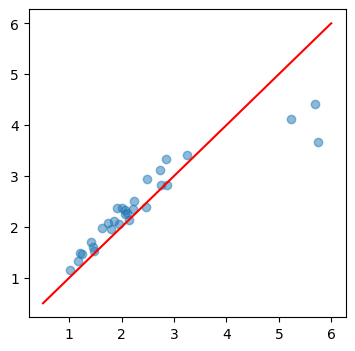

In [22]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
pearsonr
print(pearsonr(ts_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv.groupby(by='sbj')['rt'].mean()))
print(mean_squared_error(ts_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv.groupby(by='sbj')['rt'].mean()))

plt.plot(np.linspace(0.5, 6, 100), np.linspace(0.5, 6, 100), c='red')
plt.scatter(ts_df.groupby(by='sbj')['rt'].mean(),
            pred_bhv.groupby(by='sbj')['rt'].mean(), alpha=0.5);

# plt.subplot(122)
# print(pearsonr(ts_df.groupby(by='sbj')['is_high'].mean(),
#                pred_bhv.groupby(by='sbj')['ch'].mean()))
# print(mean_squared_error(ts_df.groupby(by='sbj')['is_high'].mean(),
#                pred_bhv.groupby(by='sbj')['ch'].mean()))

# plt.plot(np.linspace(0., 1, 100), np.linspace(0., 1, 100), c='red')
# plt.scatter(ts_df.groupby(by='sbj')['is_high'].mean(),
#             pred_bhv.groupby(by='sbj')['ch'].mean(), alpha=0.5);

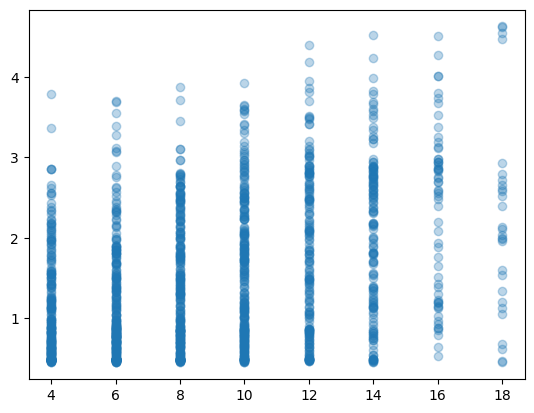

In [29]:
plt.scatter(np.abs(X_test[:, 0] - X_test[:, 1]) + np.abs(X_test[:, 0] - X_test[:, 2]) + np.abs(X_test[:, 1] - X_test[:, 2]), 
            np.abs(pred_v[:, 0] - pred_v[:, 1]) + np.abs(pred_v[:, 0] - pred_v[:, 2]) + np.abs(pred_v[:, 1] - pred_v[:, 2]), alpha=0.3);


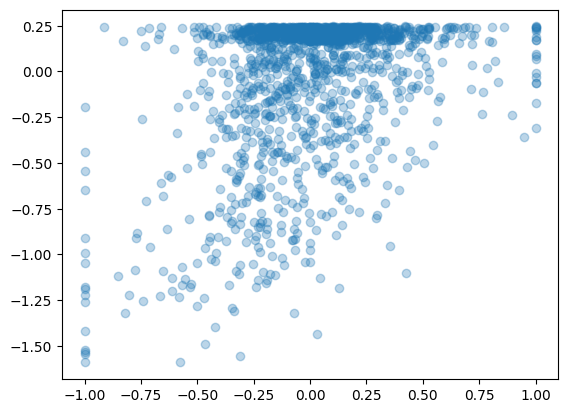

In [37]:
plt.scatter(X_test[:, 3] - X_test[:, 5], pred_v[:, 0] - pred_v[:, 2], alpha=0.3);

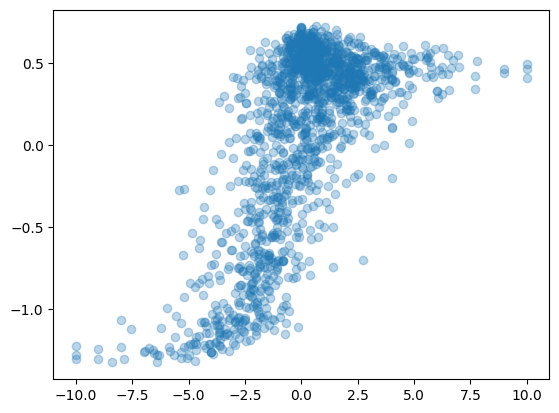

In [30]:
plt.scatter(X_test[:, 0]*X_test[:, 3] - X_test[:, 1]*X_test[:, 4], pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

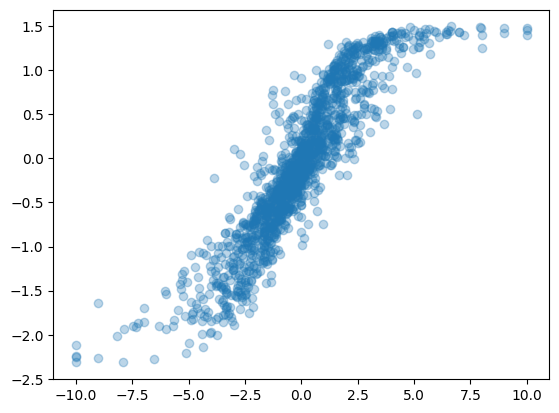

In [31]:
plt.scatter(X_test[:, 1]*X_test[:, 4] - X_test[:, 2]*X_test[:, 5], pred_v[:, 1] - pred_v[:, 2], alpha=0.3);

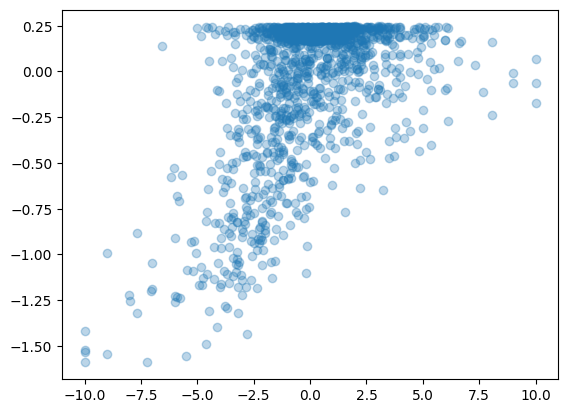

In [33]:
plt.scatter(X_test[:, 0]*X_test[:, 3] - X_test[:, 2]*X_test[:, 5], pred_v[:, 0] - pred_v[:, 2], alpha=0.3);

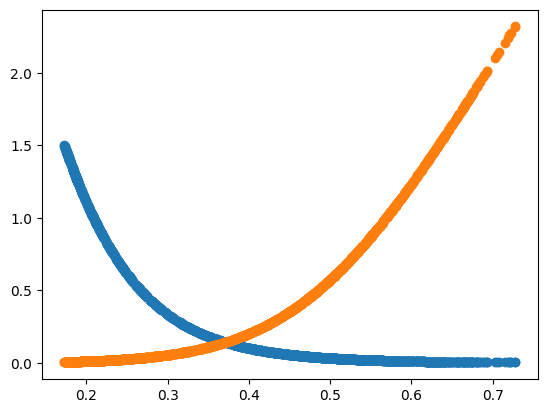

In [41]:
plt.scatter(pred_v[:, 0], pred_v[:, 1]);
plt.scatter(pred_v[:, 0], pred_v[:, 2]);

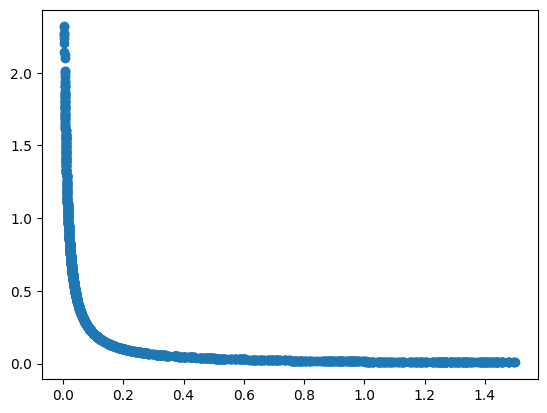

In [42]:
plt.scatter(pred_v[:, 1], pred_v[:, 2]);
# plt.scatter(pred_v[:, 0], pred_v[:, 2]);

In [43]:
import plotly.express as px

In [48]:
px.scatter_3d(x=pred_v[:, 0], y=pred_v[:, 1], z=pred_v[:, 2])

In [16]:
# plt.scatter(X[:, 0] + X[:, 1], pred[:, 0] + pred[:, 1], alpha=0.3)
# plt.scatter(X[:, 2],  pred[:, 0], alpha=0.3);
# plt.scatter(X[:, 0]*X[:, 2],  pred[:, 0], alpha=0.3)
# plt.scatter(X[:, 0]*X[:, 2] - X[:, 1]*X[:, 3], pred[:, 0] - pred[:, 1], alpha=0.3);
# plt.scatter(X[:, 0] - X[:, 1], pred[:, 0] - pred[:, 1], alpha=0.3)
# plt.scatter(X[:, 2] - X[:, 3], pred[:, 0] - pred[:, 1], alpha=0.3)